In [1]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import numpy as np
import cv2
import glob
from torchvision.transforms import CenterCrop
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
# import optuna
import wandb
import matplotlib.pyplot as plt

In [3]:
# prompt: google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip -q "/content/drive/MyDrive/learning machine learning/Black Sea Sprat.zip"

In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Custom Dataset Definition

In [6]:
class FloodSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_dir, mask_dir, img_resize_shape=(210, 210), mask_resize_shape=(210, 210), img_channel_dimensions=3, num_classes=2):
        self.root_dir = root_dir
        self.image_dir = self.root_dir + image_dir
        self.mask_dir = self.root_dir + mask_dir

        self.image_paths = glob.glob(self.image_dir + '*')
        self.mask_paths = glob.glob(self.mask_dir + '*')

        self.img_resize_shape = img_resize_shape
        self.mask_resize_shape = mask_resize_shape

        self.img_channel_dimensions = img_channel_dimensions
        self.num_classes = num_classes

    def __len__(self):
        return len(glob.glob(self.image_dir + '*'))

    def mask2probs(self, mask):
        """
        Converts a given mask image to a probability distribution over two classes: [0, 1] and [1, 0].

        Parameters:
        mask (numpy.ndarray): A 3D numpy array representing the mask image. The shape of the array is (height, width, 3).

        Returns:
        torch.Tensor: A 2D PyTorch tensor representing the probability distribution over two classes. The shape of the tensor is (height * width, 2).
        """

        # Vectorized comparison to create a mask for [0, 0, 0]
        zero_mask = np.all(mask == [0, 0, 0], axis=-1)

        # Create an array of shape (height, width, 2)
        ds = np.zeros((mask.shape[0], mask.shape[1], 2), dtype=np.float32)

        # Set the appropriate probabilities
        ds[zero_mask, 1] = 1  # [0, 0, 0] corresponds to [0, 1]
        ds[~zero_mask, 0] = 1  # anything else corresponds to [1, 0]

        # Convert to a PyTorch tensor and reshape
        ds = torch.from_numpy(ds)

        return ds

    def __getitem__(self, idx):

        # reading image from image directory
        img = cv2.imread(self.image_paths[idx])

        # resizing image to resize shape
        img = cv2.resize(img, (self.img_resize_shape[0], self.img_resize_shape[1]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 100.0
        # converting image to tensor format and reshaping channels for convolution
        img = torch.from_numpy(img).reshape(self.img_channel_dimensions, self.img_resize_shape[0], -1).float()

       # reading mask
        mask = cv2.imread(self.mask_paths[idx])

        # resizing mask to mask_resize_shape
        mask = cv2.resize(mask, (self.mask_resize_shape[0], self.mask_resize_shape[1]))

        # converting mask to binary format and applying thresholding to make it binary
        _, mask_thresholded = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

        # # converting mask to tensor format
        # mask = self.mask2probs(mask_thresholded)
        binary_mask = np.where(np.any(mask_thresholded != 0, axis=-1), 1, 0)

        # mask = torch.flatten(mask, start_dim=0, end_dim=1)

        # mask = mask.view(-1, self.mask_resize_shape[1], 2)
        binary_mask = torch.from_numpy(binary_mask).float()

        return img, binary_mask

## U-Net Network Definition

In [7]:
class UNet(nn.Module):

    def __init__(self, initial_channel, target_dimension):
        super(UNet, self).__init__()

        self.initial_channel = initial_channel
        self.feature_dim = 64


        self.init_conv_done = False
        self.conv_downwards = nn.ModuleList()
        while self.feature_dim != 512:
            if not self.init_conv_done:
                # do initial conv
                self.init_conv_done = True
                self.conv_downwards.append(
                    nn.Sequential(
                        nn.Conv2d(self.initial_channel, self.feature_dim, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(self.feature_dim),
                        nn.ReLU(),
                        nn.Conv2d(self.feature_dim, self.feature_dim, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(self.feature_dim),
                        nn.ReLU(),
                    )
                )
                self.conv_downwards.append(nn.MaxPool2d(kernel_size=2))

            else:
                # do latter convs
                self.conv_downwards.append(
                    nn.Sequential(
                        nn.Conv2d(self.feature_dim, self.feature_dim*2, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(self.feature_dim*2),
                        nn.ReLU(),
                        nn.Conv2d(self.feature_dim*2, self.feature_dim*2, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(self.feature_dim*2),
                        nn.ReLU(),
                    )
                )
                self.conv_downwards.append(nn.MaxPool2d(kernel_size=2))
                self.feature_dim *= 2

        # adding bottleneck convolutional layer
        self.bottnleneck_conv = \
            nn.Sequential(
                nn.Conv2d(self.feature_dim, self.feature_dim*2, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(self.feature_dim*2),
                nn.ReLU(),
                nn.Conv2d(self.feature_dim*2, self.feature_dim*2, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(self.feature_dim*2),
                nn.ReLU(),
            )
        # doubling feature dimension as usual after every convolution
        self.feature_dim *= 2


        self.conv_upwards = nn.ModuleList()

        # self.feature_dim should be 1024 here
        while self.feature_dim != 64:
            # print(f'while upward layer adding {self.feature_dim}')
            self.conv_upwards.append(nn.ConvTranspose2d(self.feature_dim, self.feature_dim // 2, kernel_size=2, stride=2))
            self.conv_upwards.append(
                nn.Sequential(
                    nn.Conv2d(self.feature_dim, self.feature_dim // 2, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(self.feature_dim // 2),
                    nn.ReLU(),
                    nn.Conv2d(self.feature_dim // 2, self.feature_dim // 2, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(self.feature_dim // 2),
                    nn.ReLU(),
                )
            )
            self.feature_dim //= 2

        # self.feature_dim should be = 64
        self.conv_1x1 = nn.Conv2d(in_channels=self.feature_dim, out_channels=1, kernel_size=1, stride=1, padding=1)

    def forward(self, x):

        batch_size = x.shape[0]

        # Implement the forward pass of the U-Net model here

        self.conv_outputs = []

        # print('DOWNWARDS')
        # downwards loop
        for layer in self.conv_downwards:
            # print(f'\n\napplying layer {layer}, on {x.shape}')
            x = layer(x)
            # print(f'with output {x.shape}')
            # storing conv downwards outputs
            if layer._get_name() is str('Sequential'):
                self.conv_outputs.append(x)


        # applying bottleneck layer
        x = self.bottnleneck_conv(x)


        # print (f'\n\n\nThese are the conv outputs: ')
        # for conv_output in self.conv_outputs:
        #     print (conv_output.shape)


        # print('\n\n\nUPWARDS')
        # upwards loop
        for _ in range(0, len(self.conv_upwards), 2):
            layer = self.conv_upwards[_]
        # for layer in self.conv_upwards:
            # print(f'\n\napplying transpose layer {layer}, on {x.shape}')
            x = layer(x)
            # print(f'with output {x.shape}')


            # print(f'\n\nconcatenating layer {x.shape} with {self.conv_outputs[-1].shape}')

            # cropping feature map to dims of x, before concatenating
            uncropped_conv_output = self.conv_outputs.pop()
            cropped_conv_output = CenterCrop((x.shape[2], x.shape[3]))(uncropped_conv_output)

            # concatenating cropped conv output with x
            x = torch.cat((cropped_conv_output, x), dim=1)
            # print(f'shape after concatenating {x.shape}')

            layer = self.conv_upwards[_ + 1]
            x = layer(x)

            # print(f'after applying upward conv {x.shape}')

        # print(f'applying layer {self.conv_1x1} on {x.shape}')
        x = self.conv_1x1(x)
        # x = x.view(batch_size, x.shape[-1], x.shape[-1])
        x = F.sigmoid(x).view(batch_size, x.shape[-1], x.shape[-1])

        # print(f'with output {x.shape}')

        return x





## Moving to GPU

In [8]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Creating Dataset, DataLoaders, and Splitting into Train and Test

In [12]:
# defining data directories
root_dir = '/content/Black Sea Sprat/'
image_dir = 'Black Sea Sprat/'
mask_dir = 'Black Sea Sprat GT/'

dataset = FloodSegmentationDataset(root_dir, image_dir, mask_dir)

# splitting dataset into train and test
train_split = int(0.8 * len(dataset))
test_split = int(len(dataset) - train_split)

train_dataset, test_dataset = random_split(dataset, [train_split, test_split])

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)


unet = UNet(initial_channel=3, target_dimension=64).to(device)


lr = 3e-4
# weight_decay = 1e-4

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)



## IoU Metric Calculation Function

In [13]:

def calculate_binary_iou(predicted_mask, ground_truth_mask, threshold=0.5):
    """
    Calculate IoU for binary segmentation masks.

    Parameters:
    predicted_mask (numpy.ndarray): Predicted mask of shape (H, W).
    ground_truth_mask (numpy.ndarray): Ground truth mask of shape (H, W).
    threshold (float): Threshold to convert predicted probabilities to binary values.

    Returns:
    float: The IoU score.
    """
    # Ensure masks are numpy arrays
    predicted_mask = np.asarray(predicted_mask)
    ground_truth_mask = np.asarray(ground_truth_mask)

    # Convert predicted probabilities to binary predictions (0 or 1)
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    union = np.logical_or(predicted_mask, ground_truth_mask).sum()

    # Avoid division by zero
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union

    return iou




## Training Loop

In [14]:
epochs = 50

run = wandb.init(
    # Set the project where this run will be logged
    project="unet",
    # Track hyperparameters and run metadata
    config={
        "lr": lr,
        "epochs": epochs,
    },
)


for epoch in range(epochs):


  step = 0
  for train_features, train_labels in train_loader:

    # loading features and labels, and moving to gpu
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)

    # also loading features and labels from validation set for validation IoU calculation
    test_features, test_labels = next(iter(test_loader))
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)

    # validation forward pass
    val_outputs = unet(test_features.float())

    # training forward pass
    outputs = unet(train_features.float())
    loss = loss_fn(outputs, train_labels)

    # IoU calculation and generation
    iou_value = calculate_binary_iou(outputs.cpu().detach().numpy(), train_labels.cpu().detach().numpy())
    val_iou_value = calculate_binary_iou(val_outputs.cpu().detach().numpy(), test_labels.cpu().detach().numpy())
    print(f'Step {step + 1}, Loss {loss.item()}, Train IoU {iou_value}, Val IoU {val_iou_value}')

    wandb.log({'loss': loss.item(), 'train_iou': iou_value, 'val_iou': val_iou_value})
    step += 1

    # training backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  print(f'EPOCH {epoch + 1} DONE\n\n\n')

run.finish()

wandb: Currently logged in as: aaryadev. Use `wandb login --relogin` to force relogin


Step 1, Loss 0.5787408351898193, Train IoU 0.05530377668308703, Val IoU 0.04986533483251837
Step 2, Loss 0.5652520060539246, Train IoU 0.08580056161766403, Val IoU 0.10292139701804598
Step 3, Loss 0.5475766062736511, Train IoU 0.13965052789651516, Val IoU 0.1249785680266709
Step 4, Loss 0.5443171858787537, Train IoU 0.12891393981365704, Val IoU 0.16747098447234432
Step 5, Loss 0.5307675004005432, Train IoU 0.18201635892754, Val IoU 0.21102033490437477
Step 6, Loss 0.5084324479103088, Train IoU 0.2540923147715815, Val IoU 0.23038934344175865
Step 7, Loss 0.5066478848457336, Train IoU 0.23582793246363104, Val IoU 0.27484033385065404
Step 8, Loss 0.5076805353164673, Train IoU 0.2285385837026799, Val IoU 0.28726269217679523
Step 9, Loss 0.5270377993583679, Train IoU 0.1428296327678176, Val IoU 0.19981939427618783
Step 10, Loss 0.5104765295982361, Train IoU 0.16871140334731752, Val IoU 0.21821002184029573
Step 11, Loss 0.47839099168777466, Train IoU 0.27745267060032863, Val IoU 0.2441796832

loss,█▇▅▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_iou,▁▂▃▆▆▄▆▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇█▇▇███████
val_iou,▁▅▆▆▆▆▇▇▆▆▆▇▇█▇▇█▇▇▇▇█▇▇▇█▇▇████████████
loss,0.05296
train_iou,0.83025
val_iou,0.69995


## We achieved a Train IoU of ~85% and Validation IoU of ~71%

## Inference and Metrics

In [15]:
# output of model is a mask with sigmoid applied
# pixel intensities are in a range of 0-1 (float)
# we need only 0 or 1 values for a mask image
def binary_to_mask(z):
  rows = []
  for i in range(z.shape[0]):
    cols = []
    for j in range(z.shape[1]):
      if z[i, j].item() > 0.5:
        cols.append(1)
      else:
        cols.append(0)
    rows.append(cols)

  newz = np.array(rows)
  return newz

### Loading a sample index value

In [40]:
test_sample_index = 13

In [48]:
# # converting to binary mask (image with 0, 1 as pixel intensity values)
# train_gt_mask = binary_to_mask(train_labels[test_sample_index].cpu().detach().numpy())
# plt.imshow(train_gt_mask)

In [49]:
# train_pred_mask = unet(train_features.float())[test_sample_index].cpu().detach().numpy()
# plt.imshow(binary_to_mask(z))

## Displaying Train IoU Accuracy

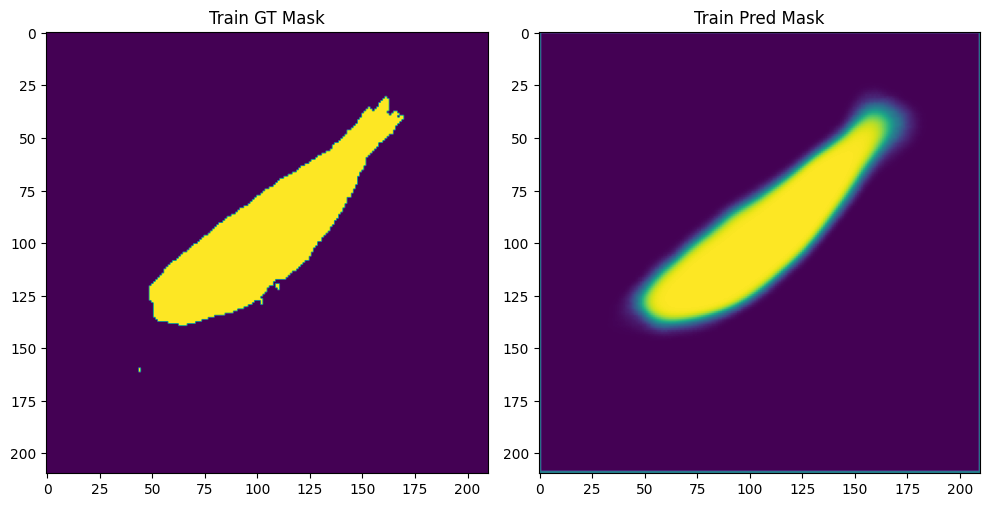

In [50]:
# Create a figure and two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


train_gt_mask = binary_to_mask(train_labels[test_sample_index].cpu().detach().numpy())
train_pred_mask = unet(train_features.float())[test_sample_index].cpu().detach().numpy()

# Display images on the subplots
axes[0].imshow(train_gt_mask)
axes[0].set_title("Train GT Mask")

axes[1].imshow(train_pred_mask)
axes[1].set_title("Train Pred Mask")

# Adjust spacing between subplots (optional)
plt.tight_layout()

plt.show()

## Displaying Test IoU Accuracy

In [25]:
# loading a new test batch (optional)
test_features, test_labels = next(iter(test_loader))
test_features = test_features.to(device)
test_labels = test_labels.to(device)

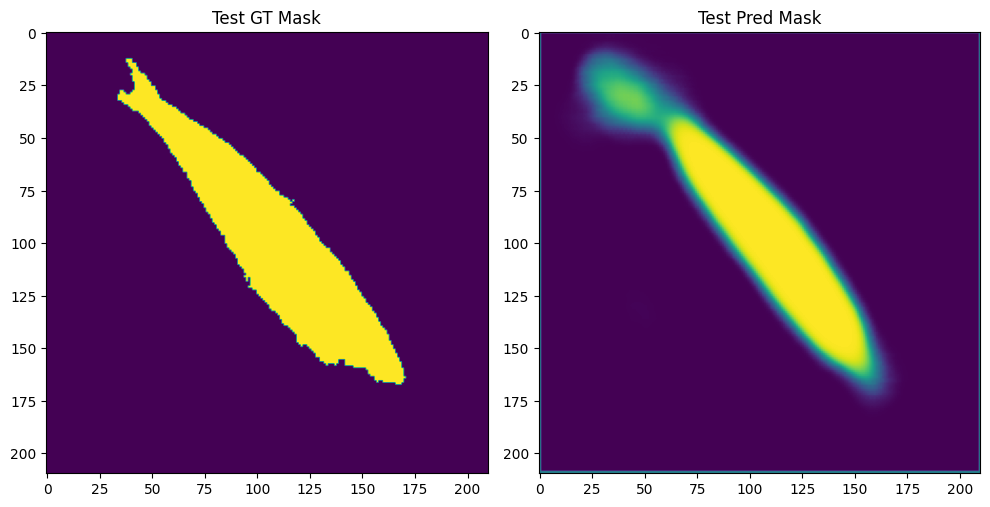

In [51]:
# Create a figure and two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


test_gt_mask = binary_to_mask(test_labels[test_sample_index].cpu().detach().numpy())
test_pred_mask = unet(test_features.float())[test_sample_index].cpu().detach().numpy()

# Display images on the subplots
axes[0].imshow(test_gt_mask)
axes[0].set_title("Test GT Mask")

axes[1].imshow(test_pred_mask)
axes[1].set_title("Test Pred Mask")

# Adjust spacing between subplots (optional)
plt.tight_layout()

plt.show()